In [3]:
from __future__ import division, print_function, absolute_import, unicode_literals
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import display
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

import bokeh.io
import bokeh.mpl
import bokeh.plotting

%config InlineBackend.figure_formats = {'png', 'retina'}
bokeh.io.output_notebook()


rc = {'lines.linewidth': 1, 
      'axes.labelsize': 14, 
      'axes.titlesize': 14, 
      'axes.facecolor': 'FFFFFF',
       }

sns.set_context('notebook', rc=rc)
sns.set_style('white', rc=rc)
sns.set_palette("colorblind")

pd.set_option('precision', 4)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.expand_frame_repr', False)

Loading BokehJS ...

In [6]:
def load_transform(fp):
    df = pd.read_json(fp)
    df = df.sort_values(by=['trip', 't'])
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    df['trip_interval'] = pd.cut(df['trip'], 
                                    bins=bins,
                                    precision=3,
                                    labels = trips_intervals)
    df['success'] = df['success'].astype(int)
    df['reward'] = df['reward'].astype(int)
    df['bad_moves'] = df['reward'].apply(lambda x: int(is_bad(x)))
    df['alpha'] = df.alpha.apply(lambda x: x['func_name'])
    df['epsilon'] = df.epsilon.apply(lambda x: x['func_name'])
    df['gamma'] = df.gamma.apply(lambda x: x['func_name'])
    return df

def is_bad(x):
    if x in [-0.5, -1.0, 9.5]:
        return True
    else:
        return False
    
def publish_results(df, n=1):
    print(tabulate(df.groupby(['trip_interval'])['success', 'bad_moves'].sum()/n,
         headers=['Trips', 'Success', 'Bad moves'],
         tablefmt='latex_booktabs'))
    
def plot_opt(data, col, max_val, num_sim=1):
    sns.heatmap(data.groupby(['trip_interval', 'gamma'])[col].sum().unstack()/num_sim,
                    vmax=max_val,
                    annot=True,
                    linewidths=0.5)
    plt.ylabel("Trip Interval")
    plt.xlabel("Gamma")
    plt.show()
    
trips_intervals = ['01 - 10', '11 - 20', '21 - 30', '31 - 40', '41 - 50', '51 - 60', '61 - 70', '71 - 80', '81 - 90', '91 - 100']

In [7]:
df = load_transform("/Users/kevin/Desktop/smartcab/results/optimal_policy2.json")

In [8]:
df.head()

,action,alpha,destination,epsilon,gamma,inital_location,initial_value,inputs,left,light,location,max_moves,moves_taken,oncoming,q_val,reward,sim_num,success,t,trip,way_point,trip_interval,bad_moves
0,None,decay1,"[4, 3]",arithmetic_average,decay4,"[6, 1]",zero,"{'oncoming': None, 'left': None, 'right': None...",None,red,"[6, 1]",20,0,None,"{'left': -0.7033903146, 'right': -0.24757967, ...",0,0,0,0,1,left,01 - 10,0
1001830,right,decay1,"[8, 4]",constant,decay4,"[5, 2]",zero,"{'oncoming': None, 'left': None, 'right': None...",None,green,"[5, 3]",25,0,None,"{'left': -0.1907535494, 'right': 1.1752059428,...",0,58,0,0,1,left,01 - 10,0
100290,left,constant,"[4, 6]",cross_entropy,decay4,"[6, 1]",zero,"{'oncoming': None, 'left': None, 'right': None...",None,red,"[6, 1]",35,0,None,"{'left': 0.0853798342, 'right': 7.6385909879, ...",-1,5,0,0,1,right,01 - 10,1
1003659,right,decay2,"[2, 6]",arithmetic_average,decay4,"[1, 2]",zero,"{'oncoming': None, 'left': None, 'right': None...",None,red,"[2, 2]",25,0,None,"{'left': -0.19717712540000001, 'right': 5.1997...",2,58,0,0,1,right,01 - 10,0
1005515,right,decay2,"[2, 1]",cross_entropy,decay4,"[2, 5]",zero,"{'oncoming': None, 'left': None, 'right': None...",None,green,"[2, 6]",20,0,None,"{'left': 1.1888717778, 'right': -0.2231042399,...",0,58,0,0,1,right,01 - 10,0


In [9]:
results = df.groupby(["alpha", "trip"]).agg(np.sum)['success'].unstack().T

In [10]:
alpha_map = {'constant': '1',
             'decay1': '1/(t + 1)',
             'decay2': '1/(t + 2)'}

epsilon_map = {'arithmetic_average': '1/t',
               'cross_entropy': '-ln(sigmoid(t + 2))',
               'constant': '1'
}

In [11]:
df['alpha'] = df['alpha'].map(alpha_map)
df['epsilon'] = df['epsilon'].map(epsilon_map)

In [12]:
def plot_grids(data, col):
    for i, e in enumerate(data['epsilon'].unique()):
        print(e)
        d = pd.DataFrame()
        d = data[data['epsilon'] == e]
        sns.heatmap(d.groupby(["alpha", "trip_interval"]).agg(np.sum)[col].unstack().T/100, annot=True)
        plt.xlabel("\nLearning rate")
        plt.ylabel("Trip interval")
        plt.title("Average success\n")
        plt.savefig("./figures/success{}".format(i))
        plt.show()
        print()

1/t


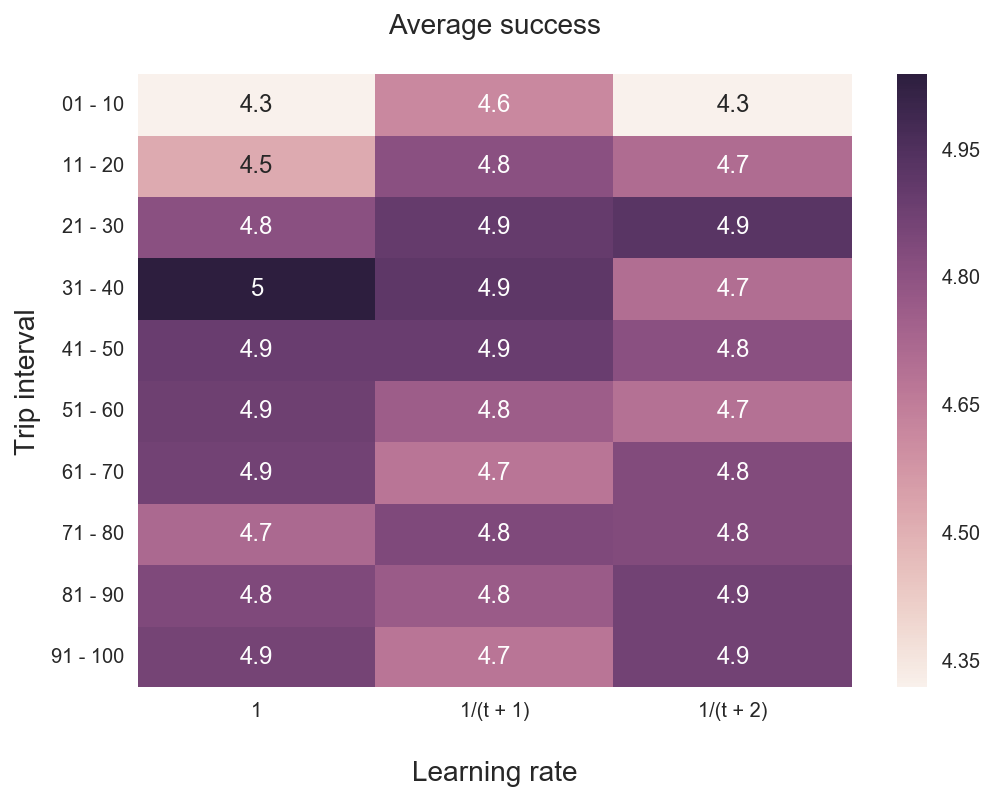


1


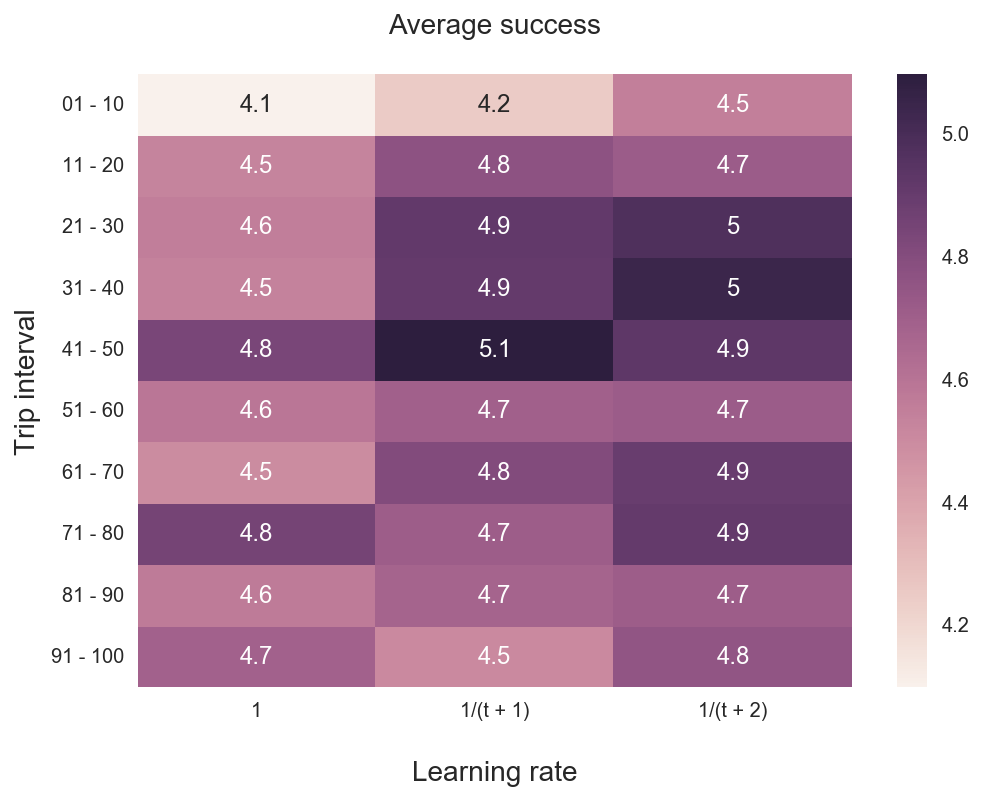


-ln(sigmoid(t + 2))


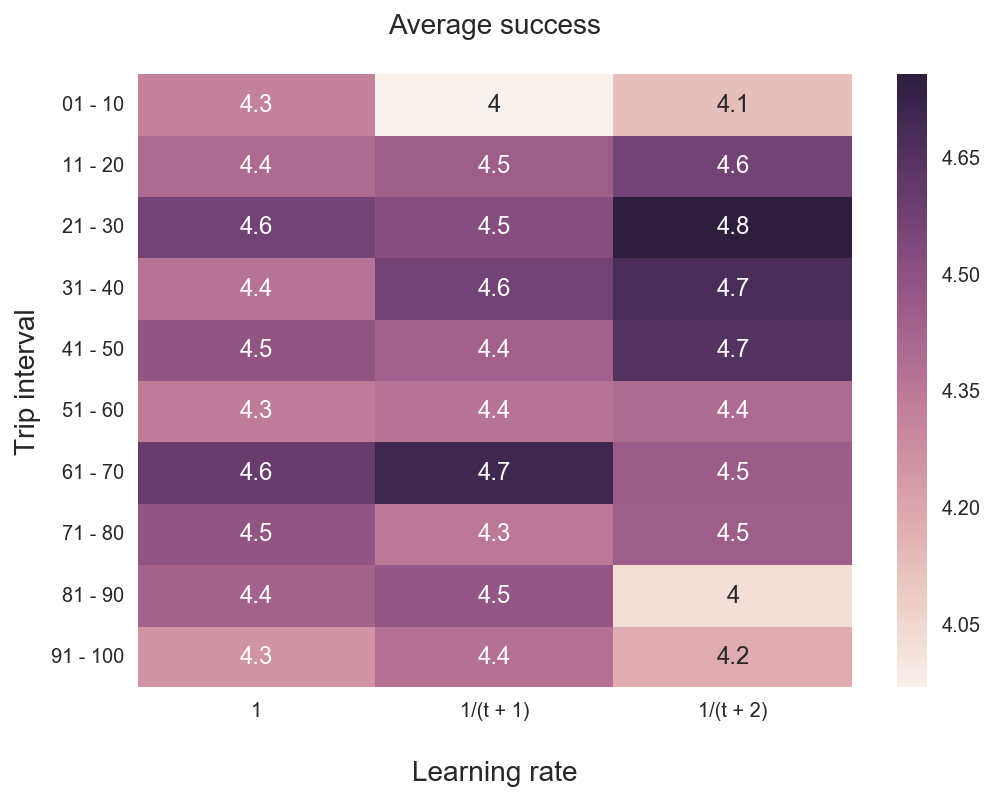

In [13]:
plot_grids(df, 'success')

In [14]:
def plot_grids(data, col):
    for i, e in enumerate(data['epsilon'].unique()):
        print(e)
        d = pd.DataFrame()
        d = data[data['epsilon'] == e]
        sns.heatmap(d.groupby(["alpha", "trip_interval"]).agg(np.sum)[col].unstack().T/100, annot=True)
        plt.xlabel("\nLearning rate")
        plt.ylabel("Trip interval")
        plt.title("Average mistakes\n")
        plt.savefig("./figures/mistakes{}".format(i))
        plt.show()
        print()

1/t


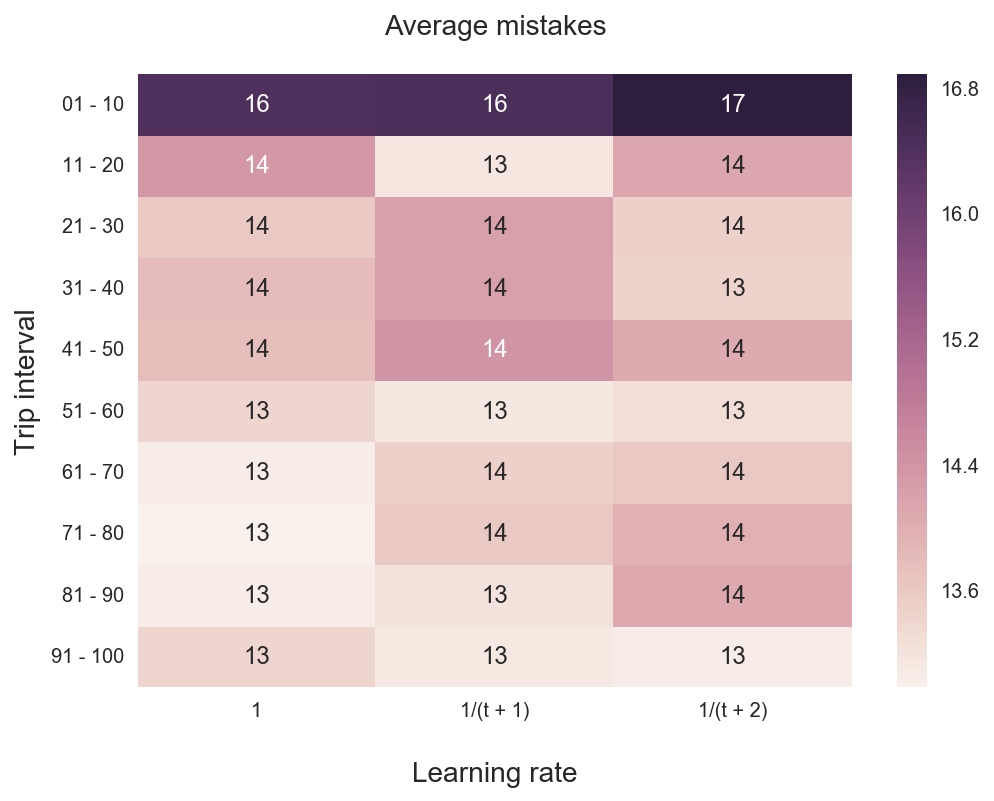


1


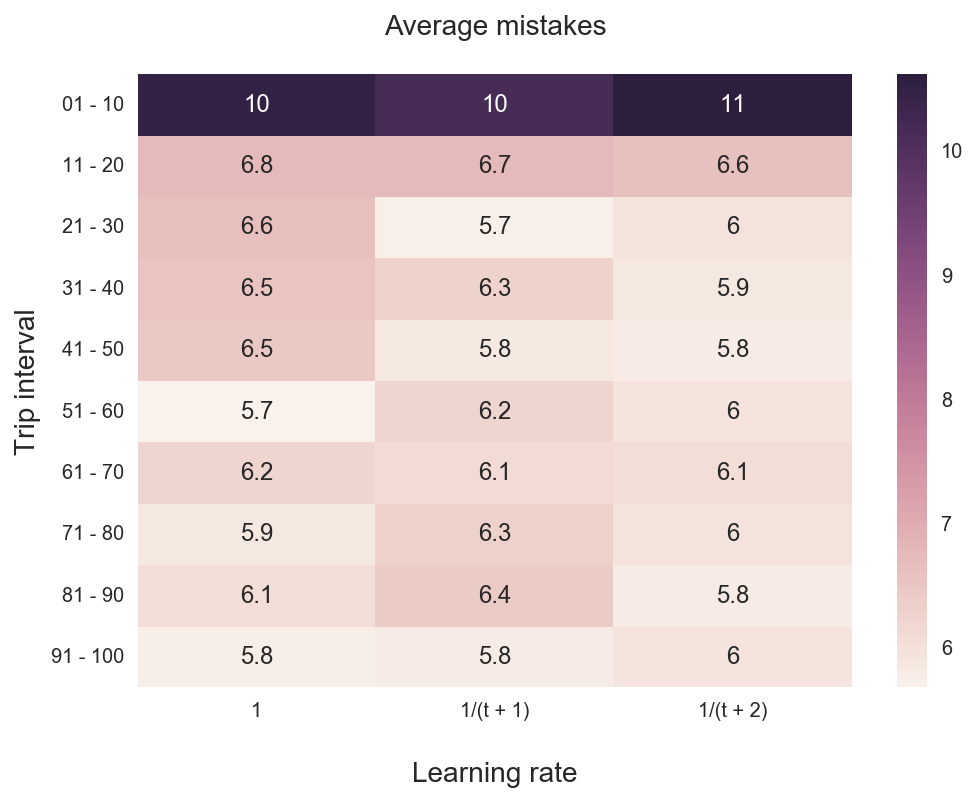


-ln(sigmoid(t + 2))


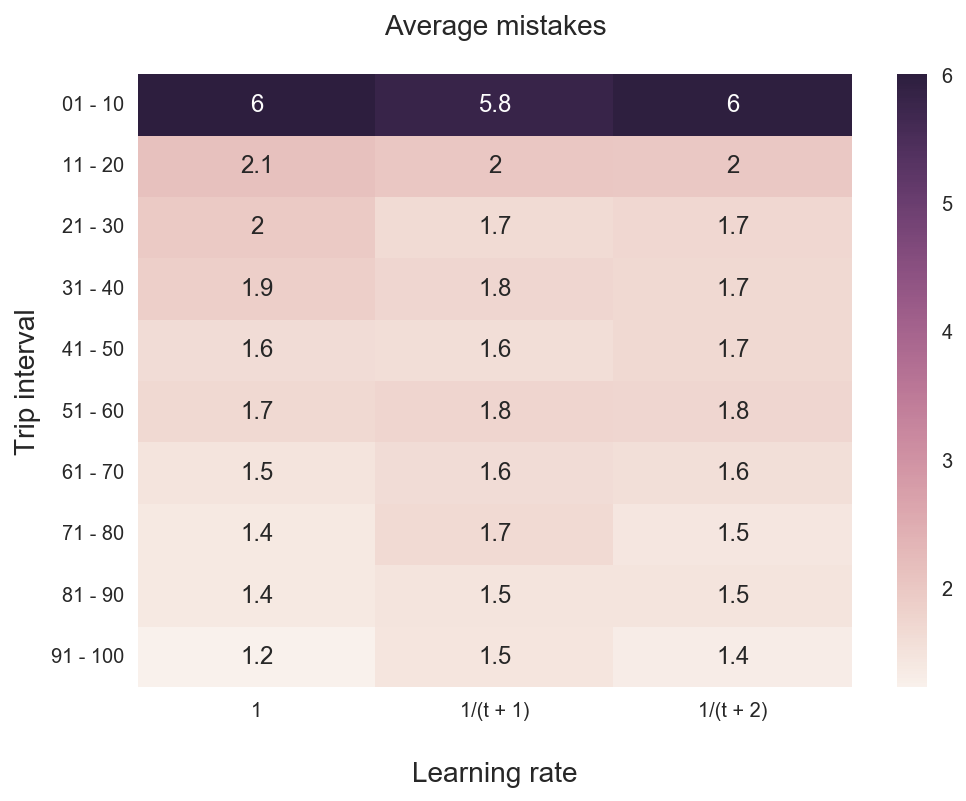

In [15]:
plot_grids(df, 'bad_moves')